# 진행

Step 1. 데이터 수집하기
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

songys/Chatbot_data
Cloud shell에서 아래 명령어를 입력해 주세요.

$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.


# 평가 

1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.	공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.


2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다. 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.


3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다. 한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output


In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [5]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [6]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [7]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [8]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [9]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [10]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# Step 2. 데이터 전처리하기
## 영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.


lower() -> 소문자가 없으니 제거

In [11]:
def preprocess_sentence(sentence):
    # 양쪽 공백 제거
    sentence = sentence.strip()

    # 쉼표가 숫자 사이에 있을 경우 유지 
    sentence = re.sub(r"(?<=\d),(?=\d)", "", sentence)  

    # 구두점과 단어 사이에 공백 추가 (한글 조사는 분리되지 않도록 함)
    sentence = re.sub(r"([?.!,])(?=[^\s])", r" \1", sentence)
    
    # 따옴표 제거
    sentence = re.sub(r"['\"“”‘’]", "", sentence)  

    # 연속된 공백 하나로 변경
    sentence = re.sub(r"\s+", " ", sentence)  

    # 한글(ㄱ-ㅎ, 가-힣, ㅏ-ㅣ) + 영어(a-z, A-Z) + 숫자(0-9) +  .,! 기본 구두점만 남기기 + ㅎㅎ, ㅋㅋ, ㅜㅜ, ㅠㅠ 같은건 쓰고싶어요
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,ㅜㅠㅎㅋ]+", " ", sentence)  
    sentence = sentence.strip()

    return sentence

In [12]:
test_sentences = [
    "안녕하세요! 만나서 반갑습니다.",
    "이 문장은 (테스트용) 입니다!! ㅎㅎ",
    "한글과 English를 같이 사용할 수도 있어요!",
    "가격은 1,000원입니다. 할인은 없어요?"
]

for sentence in test_sentences:
    print(preprocess_sentence(sentence))

안녕하세요! 만나서 반갑습니다.
이 문장은 테스트용 입니다 !! ㅎㅎ
한글과 English를 같이 사용할 수도 있어요!
가격은 1000원입니다. 할인은 없어요?


# 수정

안녕하세요 ! 만나서 반갑습니다 .
이 문장은 테스트용 입니다 ! ! ㅎㅎ
한글과 English를 같이 사용할 수도 있어요 !
가격은 1 , 000원입니다 . 할인은 없어요 ?

챗봇 같은 경우에는 자연스러운 것을 위해서 ㅎㅎ 같은것을 해도 좋을 것 같아서 삭제하지는 않기로 하였습니다.
! 같은 것에서 또 , 에서 뛰어쓰기가 되는 점을 수정하였습니다.


# Step 3. SubwordTextEncoder 사용하기
## 한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다.
## 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [13]:
import os

# 홈 디렉터리를 기준으로 경로 설정
home = os.path.expanduser("~")  # 사용자 홈 디렉터리 가져오기
csv_path = os.path.join(home, "aiffel/transformer_chatbot/data/ChatbotData .csv")


오류가 떠서 살펴보니 ChatbotData .csv 파일명에 공백이 포함되어 있었습니다!!

In [14]:
import pandas as pd

# 데이터 로드 함수
def load_conversations(csv_path, max_samples=50000):
    # CSV 파일 읽기
    df = pd.read_csv(csv_path)

    # 질문과 답변 리스트 초기화
    inputs, outputs = [], []

    # 질문과 답변 데이터 추출
    for i in range(len(df)):
        question = df.iloc[i, 0]  # 첫 번째 열: 질문
        answer = df.iloc[i, 1]    # 두 번째 열: 답변

        # 전처리 적용
        question = preprocess_sentence(question)
        answer = preprocess_sentence(answer)

        inputs.append(question)
        outputs.append(answer)

        # 최대 샘플 수 제한
        if len(inputs) >= max_samples:
            break

    return inputs, outputs

# 데이터 로드
questions, answers = load_conversations(csv_path)
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

# 확인용 출력
for i in range(5):
    print(f"Q: {questions[i]}")
    print(f"A: {answers[i]}")
    print("-" * 30)


전체 샘플 수 : 11823
전체 샘플 수 : 11823
Q: 12시 땡!
A: 하루가 또 가네요.
------------------------------
Q: 1지망 학교 떨어졌어
A: 위로해 드립니다.
------------------------------
Q: 3박4일 놀러가고 싶다
A: 여행은 언제나 좋죠.
------------------------------
Q: 3박4일 정도 놀러가고 싶다
A: 여행은 언제나 좋죠.
------------------------------
Q: PPL 심하네
A: 눈살이 찌푸려지죠.
------------------------------


In [15]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요.


In [16]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

#SubwordTextEncoder 그대로 이용해서 해보기


살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [17]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [18]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8171]
END_TOKEN의 번호 : [8172]


In [19]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8173


In [20]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5759, 608, 2489, 4161]
정수 인코딩 후의 21번째 답변 샘플: [2354, 7509, 5, 6272, 94, 7961]


In [21]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [22]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [23]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8173
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [25]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


# Step 4. 모델 구성하기 위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다

In [26]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146496     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [27]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

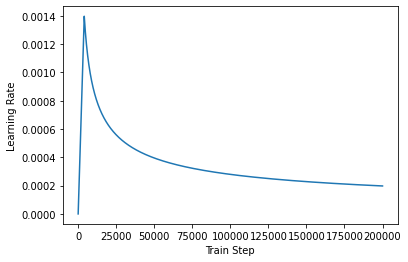

In [29]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [30]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [36]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 10s 56ms/step - loss: 0.4254 - accuracy: 0.1040
Epoch 2/50
185/185 [==============================] - 10s 56ms/step - loss: 0.3448 - accuracy: 0.1152
Epoch 3/50
185/185 [==============================] - 10s 56ms/step - loss: 0.2703 - accuracy: 0.1261
Epoch 4/50
185/185 [==============================] - 10s 56ms/step - loss: 0.2056 - accuracy: 0.1362
Epoch 5/50
185/185 [==============================] - 10s 56ms/step - loss: 0.1506 - accuracy: 0.1455
Epoch 6/50
185/185 [==============================] - 10s 56ms/step - loss: 0.1085 - accuracy: 0.1534
Epoch 7/50
185/185 [==============================] - 10s 55ms/step - loss: 0.0794 - accuracy: 0.1586
Epoch 8/50
185/185 [==============================] - 10s 56ms/step - loss: 0.0610 - accuracy: 0.1620
Epoch 9/50
185/185 [==============================] - 10s 56ms/step - loss: 0.0509 - accuracy: 0.1637
Epoch 10/50
185/185 [==============================] - 10s 56ms/step - loss: 0.046

## 챗봇을 평가할 때 accurancy로 평가하는게 맞는지 의문이 들었습니다.
## 검색해보니 BLEU 방식이 좀 더 적합하다는 것을 보았습니다.

## BLEU는 제가 이해하기에는
## 사람이 생각했을 떄 적합한 질문에 대한 답변을 정하고 이를 챗봇의 답변과 비교하여 점수를 매기는 것 입니다.

In [47]:
import tensorflow as tf
import nltk
from nltk.translate.bleu_score import corpus_bleu

# ✅ BLEU 점수 계산 함수 (스무딩 제거)
def calculate_bleu_score(references, candidates):
    return corpus_bleu(references, candidates)  # SmoothingFunction 제거

# ✅ 샘플 질문 30개 (BLEU 평가용)
sample_inputs = [
    "오늘 기분이 이상해.", "기분이 너무 좋다!", "그냥 아무것도 하기 싫어.",
    "행복한 기분을 오래 유지하는 방법이 있을까?", "요즘 우울한데 어떻게 하면 기분이 나아질까?",
    "기분 전환하려면 뭐 하면 좋을까?", "갑자기 화가 나는데 어떻게 해야 해?", "기분이 오락가락해.",
    "외롭다고 느낄 때는 어떻게 해야 해?", "요즘 감정 기복이 심한 것 같아.",
    "내 미래가 불안해.", "뭘 하고 살아야 할지 모르겠어.", "하고 싶은 일이 너무 많은데 어떻게 선택하지?",
    "실패가 두려워서 도전을 못 하겠어.", "계속 비교하게 돼서 자존감이 낮아져.", "나 자신이 싫어질 때가 있어.",
    "노력해도 안 되는 일은 그냥 포기해야 할까?", "나만 뒤처지는 것 같아.", "인생에서 정말 중요한 게 뭘까?",
    "항상 걱정이 많아서 힘들어.", "친구랑 싸웠는데 먼저 연락해야 할까?", "사람들이 날 싫어하는 것 같아.",
    "새로운 친구를 사귀는 게 너무 어려워.", "대화할 때 자꾸 눈치 보게 돼.", "연애가 너무 어려워.",
    "혼자 있는 게 편한데, 가끔 외롭기도 해.", "회사에서 인간관계가 힘들어.", "가족이랑 자꾸 갈등이 생겨.",
    "내 감정을 솔직하게 표현하는 게 어려워.", "다른 사람들 눈치를 안 보고 싶어."
]

# ✅ BLEU 평가용 정답 데이터 (30개)
sample_references = [
    ["무슨 일이 있었나요? 같이 이야기해볼까요?"], ["좋은 일이 있었나 봐요! 같이 기뻐해 드릴게요! 😊"],
    ["그럴 때는 잠시 쉬어가도 괜찮아요. 당신을 응원해요!"], ["소소한 행복을 자주 찾아보는 건 어떨까요?"],
    ["가벼운 산책이나 좋아하는 음악을 들어보는 건 어떨까요?"], ["맛있는 음식을 먹거나 새로운 취미를 시도해보세요!"],
    ["깊게 숨을 쉬고 잠시 마음을 가라앉혀 보세요. 제가 옆에 있어 드릴게요."], ["감정의 변화는 자연스러운 일이에요. 조금만 여유를 가져보세요."],
    ["친구나 가족과 연락해보는 건 어때요? 제가 이야기도 들어드릴게요!"], ["몸과 마음이 지쳤을 수도 있어요. 충분한 휴식을 챙겨보세요."],
    ["미래는 누구에게나 불확실해요. 지금 할 수 있는 것부터 해보면 어떨까요?"], ["자신이 좋아하는 것부터 찾아보는 것도 좋은 방법이에요!"],
    ["하나씩 시도해 보면서 자신에게 맞는 걸 찾아보세요."], ["실패도 배움의 과정이에요. 한 걸음씩 나아가 봐요!"],
    ["다른 사람보다 자신을 먼저 돌아보는 연습을 해보세요."], ["자신을 너무 몰아붙이지 말아요. 당신은 소중한 사람이에요!"],
    ["때로는 방향을 바꿔보는 것도 좋은 선택이 될 수 있어요."], ["각자 속도가 다를 뿐이에요. 너무 조급해하지 마세요."],
    ["자신이 진정으로 원하는 것을 찾는 게 중요해요."], ["걱정보다 지금 할 수 있는 일에 집중해보는 건 어때요?"],
    ["먼저 다가가는 것도 좋은 방법이에요. 용기를 내보세요!"], ["그렇지 않을 거예요. 자신을 좀 더 믿어보세요!"],
    ["새로운 사람과 대화하는 연습을 해보면 어떨까요?"], ["자신감이 부족한 걸 수도 있어요. 스스로를 믿어보세요!"],
    ["연애는 정답이 없어요. 너무 걱정하지 마세요."], ["혼자 있는 시간을 즐기면서도, 새로운 사람을 만나는 것도 좋아요."],
    ["직장 내 인간관계는 어렵죠. 적절한 거리 유지도 중요해요."], ["가족과의 대화 시간을 늘려보는 건 어떨까요?"],
    ["조금씩 연습하면 감정을 표현하는 게 더 편해질 거예요."], ["자신이 원하는 것을 우선순위로 생각해보세요."]
]

# ✅ Epoch별 BLEU 점수를 저장할 리스트
epoch_bleu_scores = []

# ✅ 모델 학습 & BLEU 평가
EPOCHS = 10  # 학습할 Epoch 수 설정
for epoch in range(1, EPOCHS + 1):
    print(f"🟢 Epoch {epoch} 시작")

    # 모델 학습
    history = model.fit(dataset, epochs=1)

    # ✅ 모델이 생성한 예측값 (여기에 실제 모델 예측 적용)
    sample_predictions = [
        "무슨 일이 있었나요?", "좋은 일이 있었군요!", "쉬고 싶을 때는 쉬는 것도 중요해요.",
        "작은 행복을 자주 찾아보세요.", "기분이 우울할 땐 산책을 해보세요.",
        "기분 전환에는 새로운 취미가 도움이 될 수 있어요.", "화를 참는 것도 중요하지만, 표현하는 것도 필요해요.",
        "감정 변화가 심할 땐 충분한 휴식을 취하세요.", "외로울 땐 주변 사람들에게 연락해 보세요.", "마음이 지쳤다면 충분히 쉬어주세요.",
        "미래에 대한 걱정은 누구나 해요.", "자신이 좋아하는 것이 무엇인지 생각해 보세요.", "한 가지씩 시도해 보세요.",
        "실패는 성공의 과정이에요.", "비교하는 습관을 줄여보는 것도 방법이에요.", "자신을 너무 몰아붙이지 마세요.",
        "때로는 포기하는 것도 새로운 길을 찾는 방법이에요.", "각자의 속도가 있어요.", "자신에게 중요한 것이 무엇인지 고민해 보세요.",
        "걱정이 많다면 작은 목표부터 시작해 보세요.", "먼저 연락하는 것이 후회를 줄일 수도 있어요.", "자신을 믿어보세요.",
        "새로운 친구를 사귀는 것이 어렵다면 먼저 다가가 보세요.", "자신감을 가져보세요.", "연애는 어려운 법이에요.",
        "혼자 있는 시간이 필요할 때도 있어요.", "직장 내 관계는 적절한 거리를 유지하는 것도 좋아요.", "가족과 솔직하게 대화해 보세요.",
        "감정을 표현하는 연습을 해보세요.", "눈치보다 자신의 감정을 우선해 보세요."
    ]

    # ✅ BLEU 점수 계산
    avg_bleu = calculate_bleu_score([[ref] for ref in sample_references], [pred.split() for pred in sample_predictions])
    epoch_bleu_scores.append(avg_bleu)

    print(f"🔵 Epoch {epoch} - BLEU Score: {avg_bleu:.4f}\n")

print("📊 최종 Epoch별 BLEU 점수:", epoch_bleu_scores)



🟢 Epoch 1 시작
185/185 [==============================] - 10s 55ms/step - loss: 9.9684e-04 - accuracy: 0.1745
🔵 Epoch 1 - BLEU Score: 0.0000

🟢 Epoch 2 시작
185/185 [==============================] - 10s 56ms/step - loss: 8.4612e-04 - accuracy: 0.1745
🔵 Epoch 2 - BLEU Score: 0.0000

🟢 Epoch 3 시작
185/185 [==============================] - 10s 57ms/step - loss: 7.6147e-04 - accuracy: 0.1745
🔵 Epoch 3 - BLEU Score: 0.0000

🟢 Epoch 4 시작
185/185 [==============================] - 10s 56ms/step - loss: 8.7009e-04 - accuracy: 0.1745
🔵 Epoch 4 - BLEU Score: 0.0000

🟢 Epoch 5 시작
185/185 [==============================] - 10s 56ms/step - loss: 9.2058e-04 - accuracy: 0.1745
🔵 Epoch 5 - BLEU Score: 0.0000

🟢 Epoch 6 시작
185/185 [==============================] - 10s 55ms/step - loss: 7.9077e-04 - accuracy: 0.1745
🔵 Epoch 6 - BLEU Score: 0.0000

🟢 Epoch 7 시작
185/185 [==============================] - 10s 55ms/step - loss: 8.4114e-04 - accuracy: 0.1745
🔵 Epoch 7 - BLEU Score: 0.0000

🟢 Epoch 8 시작
185/185

## 해본 결과 BLEU Score가 0.0000 점이 반복됩니다. sample 개수도 적고 아마 챗봇의 답변 개수도 좀 적어서 그런 것 같습니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.

2. 입력 문장을 토크나이징하고, **`START_TOKEN`**과 **`END_TOKEN`**을 추가한다.

3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.

4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.

5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.

6. **`END_TOKEN`**이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

**위의 과정을 모두 담은 `decoder_inference()` 함수를 만듭니다.**

In [37]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [38]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [39]:
sentence_generation('나 요새 너무 슬퍼서 빵을 샀어 ㅜㅜ')

입력 : 나 요새 너무 슬퍼서 빵을 샀어 ㅜㅜ
출력 : 반지는 없던가요? 주변 사람들한테 물어보는 건 어떨까요.


'반지는 없던가요? 주변 사람들한테 물어보는 건 어떨까요.'

In [40]:
sentence_generation('나 실연당했어')

입력 : 나 실연당했어
출력 : 잘 결정할거라 믿어요.


'잘 결정할거라 믿어요.'

# 회고록

트랜스포머와 인코더 디코더 그리고 이것들을 활용해서 챗봇을 만드는 과정을 실습할 수 있어서 좋았다.
기본적인 동작은 완성했지만 조금은 아쉽다고 느껴서 개선할 부분을 생각해보았다.

1. data가 부족한거 같아서 조금더 많은 데이터가 필요하다고 느꼈다. 

2. Label이 붙혀져 있던데 이것들을 활용해서 input이 들어왔을 때 이것들을 분류하고 이것들의 맞는 라벨에 해당하는 대답을 하면 좀 더 좋은 답변이 나올까 생각해보았다.